# Making trackpy fast(er)

This notebook explains specific features built into `trackpy` to boost performance, and it also provides some general suggestions on how to make your particle tracking run faster.

First, set up matplotlib...

In [1]:
%matplotlib inline
import matplotlib
from matplotlib.pyplot import imshow

Let's check the `trackpy` version. If it's not 0.3.0 or greater, the following *may* not work.

In [2]:
import trackpy
trackpy.__version__

'0.2.3-296-g3e96836'

## General advice

### Subnetworks

As we'll see in the examples below, the need to resolve "subnetworks" — in which multiple neighboring particles in one frame could correspond to multiple particles in the next — can drastically slow down tracking. There is a seprate tutorial on dealing with (excessive) subnetworks. In the text below, we'll look at some methods for finding out just how much a of a problem subnetworks are in your application, so that you can weigh the various remedies against a potential loss of accuracy.

### Feature-finding: The best advice

Judicious use of the `minmass` and/or `threshold` parameters during feature-finding, as described in the "walkthrough" tutorial notebook, can considerably speed up feature-finding, linking, and analysis of tracks. The best way to speed up a computation is usually to avoid doing it at all.

### Feature-finding: The details

The `locate()` and `batch()` functions for feature-finding can use either of two engines for their work, as specified by the optional `engine` parameter:

- The `numba` engine is reasonably fast. It is the default when numba is installed (see above).
- The `python` engine is currently slightly more accurate, but considerably slower.

In addition, both engines do some extra work that you might not always need:

- They iteratively try to refine the position of the feature centroid, for the best possible subpixel accuracy. This can be turned off with the parameter `max_iterations=0`.
- They compute extra data about the feature, such as its eccentricity. This can be turned off with `characterize=False`.

**Note:** Before sacrificing accuracy for performance, it's best to know objectively how much performance you are gaining. Read on to the Advanced Topics section for information about how to time feature-finding.

## Using numba for acceleration

Two key algorithms in `trackpy` can be sped up by the [`numba`](http://numba.pydata.org) array-based just-in-time compiler for Python:

- Iteratively refining the centroids of features, for better subpixel resolution.
- Resolving subnetworks, as part of the linking process.

The source code actually contains distinct Python and numba versions of each — and not one numba version but several, each optimized for a different use, and for 2D and 3D images. The default setting is to use the appropriate numba version when possible, but to fall back on the general-purpose Python version if numba is unavailable. You can also control these choices manually, using the `engine` argument to `locate()`, and the `link_strategy` argument when linking.

If you don't have `numba`, we recommend using the Anaconda or Canopy scientific Python distributions, which include `numba` and many other useful packages. Note that it can be difficult to install outside of these distributions.

### Theoretical performance diagnostics: `performance_report()`

`trackpy` provides an easy way to check whether your system is configured for the best performance. Currently, it reports only whether `numba` is working.

In [3]:
import trackpy.diag
trackpy.diag.performance_report()

Yes, but could it be faster?
FAST: numba is available and enabled (fast subnets and feature-finding).


## Advanced topics

### Empirical performance diagnostics: Timing and profiling

What follows is a crash course in how to evaluate the performance of tracking. The general suggestions given above are good starting points, but they are just that — general suggestions. For your *specific* application, you need *specific* data about how long the computation takes, and how the computer is spending its time. This information may help you make your own adjustments to your tracking method, or it may help you when asking the `trackpy` developers for assistance (chances are we'll be happy to help!).

You will use these techniques with your own data, but let's use the data from the "walkthrough" tutorial.

### Setup

In [4]:
import trackpy as tp
import pims

In [5]:
frames = pims.open('../sample_data/bulk_water/*.png', as_grey=True)

The speed at which we can read images from disk is not something we can hope to improve much, so let's get that out of the way before we do our tests. Also, we don't need to use all the frames for this example (though you're welcome to).

In [6]:
# This gets the image data out of the pims ImageSequence object, and into a good old list in memory.
frames_preload = list(frames[:50])

Just so we don't forget what these images look like:

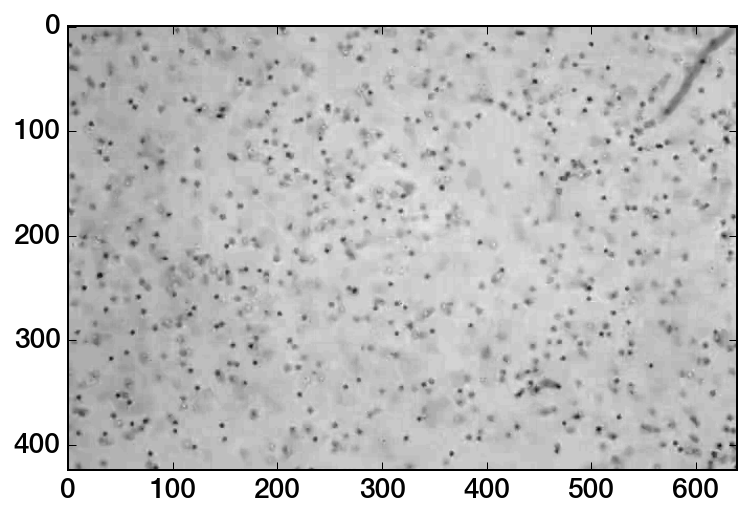

In [7]:
imshow(frames_preload[0], cmap=matplotlib.cm.gray)

Before we identify features, we need to give `trackpy` a chance to "warm up" — initialize `fftw` and compile certain functions, if it hasn't done so already. So we'll find features in just 2 frames: 

In [8]:
f2 = tp.batch(frames_preload[:3], 11, minmass=100, invert=True)
_ = tp.batch(frames_preload[:3], 11, minmass=100, invert=True, characterize=False)

Frame 2: 506 features


### Timing

Let's find out — precisely — how long it takes to find features in a single frame. You'll notice that the following cell begins with the line `%%timeit`. This is an example of a *cell magic*, which gives IPython special instructions about how to run the rest of the cell.

In [9]:
%%timeit
f1 = tp.batch(frames_preload[:1], 11, minmass=100, invert=True)

Frame 0: 500 features
10 loops, best of 3: 89.7 ms per loop


`%%timeit` runs the same code multiple times and returns a somewhat accurate measurement of execution time. We can use it to see how much faster we can find features in this image when we turn off centroid refinement and feature characterization:

In [10]:
%%timeit
f1 = tp.batch(frames_preload[:1], 11, minmass=100, invert=True, 
              max_iterations=0, characterize=False)

Frame 0: 499 features
10 loops, best of 3: 78.8 ms per loop


One thing to note is that the ratio of features to pixels is rather low in this image. If you were finding features in a dense packing of particles, the timing difference could be much more significant.

### Profiling

Next, we'll try to get a sense of what's taking so long. The `%%prun` cell magic instructs IPython to run the rest of the cell's code using a *profiler*.

In [11]:
%%prun
f = tp.batch(frames_preload, 11, minmass=100, invert=True)

Frame 49: 522 features
 

When execution is complete, a pager will pop up in the lower portion of the notebook window. This is the profiler output. We reproduce a portion of it here. Your results will depend on your data and the computer you are using.

         123225 function calls (121986 primitive calls) in 4.480 seconds

    Ordered by: internal time

    ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       50    2.709    0.054    2.709    0.054 {scipy.ndimage._nd_image.min_or_max_filter}
       50    0.481    0.010    0.481    0.010 {scipy.ndimage._nd_image.binary_erosion}
      100    0.299    0.003    0.299    0.003 {scipy.ndimage._nd_image.correlate1d}
      100    0.205    0.002    0.205    0.002 {scipy.ndimage._nd_image.uniform_filter1d}
      100    0.128    0.001    0.128    0.001 {method 'nonzero' of 'numpy.ndarray' objects}
       50    0.079    0.002    0.164    0.003 feature.py:103(refine)
      100    0.078    0.001    0.078    0.001 {numpy.core.multiarray.where}
      100    0.053    0.001    0.053    0.001 {method 'query_pairs' of 'scipy.spatial.ckdtree.cKDTree' objects}
       50    0.036    0.001    0.607    0.012 preprocessing.py:14(bandpass)
       50    0.033    0.001    0.195    0.004 feature.py:27(percentile_threshold)
       50    0.032    0.001    2.989    0.060 feature.py:36(local_maxima)
       50    0.029    0.001    0.526    0.011 uncertainty.py:12(measure_noise)

This is a record of how the computer spent its time while finding features. The various numbers are explained in the [documentation for the Python `profiler` module](http://docs.python.org/2/library/profile.html#instant-user-s-manual). You shouldn't try to understand every line, but you can get some idea of which functions are called for each frame (multiples of 50), and which are called for each particle. Note that `{functions in braces}` are written in C, not Python, are not part of `trackpy`, and tend to be less user-serviceable.

Now let's look at the linking step. Once again, we'll prime `trackpy`, to avoid distorting our results with one-time setup code:

In [12]:
# Use a large search_range, to be sure that numba subnet code is compiled and used.
t1 = tp.link_df(f2, 10, memory=3)

Frame 2: 506 trajectories present


In [13]:
%%prun
t = tp.link_df(f, 5, memory=3)

Frame 49: 522 trajectories present
 

         770140 function calls (766921 primitive calls) in 1.652 seconds

    Ordered by: internal time

    ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       51    0.229    0.004    1.180    0.023 linking.py:926(link)
      149    0.140    0.001    0.322    0.002 {map}
    28925/28825    0.096    0.000    0.099    0.000 {numpy.core.multiarray.array}
       49    0.082    0.002    0.240    0.005 linking.py:1182(assign_candidates)
       49    0.077    0.002    0.080    0.002 {method 'query' of 'scipy.spatial.ckdtree.cKDTree' objects}
       49    0.073    0.001    0.118    0.002 linking.py:1069(_assign_links)
    25945    0.064    0.000    0.179    0.000 linking.py:368(__init__)
    27415    0.048    0.000    0.117    0.000 numeric.py:394(asarray)
    25945    0.042    0.000    0.042    0.000 linking.py:300(__init__)
    54280    0.040    0.000    0.051    0.000 {method 'sort' of 'list' objects}
       50    0.039    0.001    0.039    0.001 {pandas.lib.clean_index_list}
        1    0.037    0.037    1.652    1.652 linking.py:470(link_df)
       98    0.031    0.000    0.097    0.001 linking.py:32(rebuild)
      300    0.024    0.000    0.043    0.000 common.py:303(_isnull_ndarraylike)
    54115    0.022    0.000    0.022    0.000 linking.py:345(track)
    54280    0.021    0.000    0.021    0.000 linking.py:47(<lambda>)
      101    0.021    0.000    0.021    0.000 {method 'get_indexer' of 'pandas.index.IndexEngine' objects}
    112445    0.018    0.000    0.018    0.000 {method 'append' of 'list' objects}
     1265    0.018    0.000    0.018    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    25945    0.018    0.000    0.030    0.000 linking.py:196(add_point)
    89361/86242    0.017    0.000    0.019    0.000 {len}
      136    0.016    0.000    0.021    0.000 linking.py:1375(numba_link)

This goes much faster than feature identification, though to be fair, we have far, far more pixels than particles. Note the calls to `numba_link` at the end of the report; this is the subnet resolution code referred to above. If you require a large `search_range`, these computations can dramatically slow down linking. As it is, they are under control.

### `pyfftw` and the frequency-domain bandpass

`trackpy` performs bandpass filtering to prepare an image for feature-finding. As of version 0.3, this is done with convolution; formerly, it was done using fast Fourier transforms (FFT). The two methods yield very close results, but the convolution method is roughly twice as fast. 

Because the two methods are *not* mathematically identical, `trackpy` still includes the FFT method in case you would like to use it (or just compare its results). This method is not available as part of `locate()`; you must perform the bandpass separately and then call `locate()` with `preprocess=False`. You can perform the FFT bandpass with one of two functions:

- `trackpy.preprocessing.legacy_bandpass()` uses the FFT functions built into numpy.
- `trackpy.preprocessing.legacy_bandpass_fftw()` uses the FFTW library, an exceptionally fast implementation of FFT. `pyfftw` is the module that lets Python programs use it. Like numba it is optional, but it can speed up the bandpass operation by a factor of ~3. (The default method now in `trackpy` is faster still.)

You should be able to install FFTW from your Linux package manager, or on the Mac using [Homebrew](http://brew.sh) (with the command `brew install fftw`). Once you've done that, `pyfftw` itself should install with `pip install pyfftw`

### Neighbor-finding strategy: KDTree

An important operation in tracking (i.e. linking) is finding all the particles that are close to a certain point in space. `trackpy` has two ways of doing this:

- A KDTree, which only handles more standard cases (e.g. Euclidean geometries) and is written in C. (This is the default.)
- A hash table written in pure Python. It is very extensible but tends to be slower.

The method is set by the `neighbor_strategy` argument to the various linking functions, which again defaults to KDTree. The KDTree is a standard part of `scipy`; if you can run `trackpy` at all, it is enabled.

--------

Well, I hope you've enjoyed this brief tour of `trackpy` performance. Just remember that if you come up with new ways to improve performance, the `trackpy` community will be interested!